In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
df = pd.read_csv('/content/airline_passengers.csv')
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.duplicated().sum()

0

In [4]:
df.rename(columns = {'Thousands of Passengers':'Passengers'}, inplace = True)

In [5]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.isnull().sum()

,0
Month,0
Passengers,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [9]:
df.set_index('Month', inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


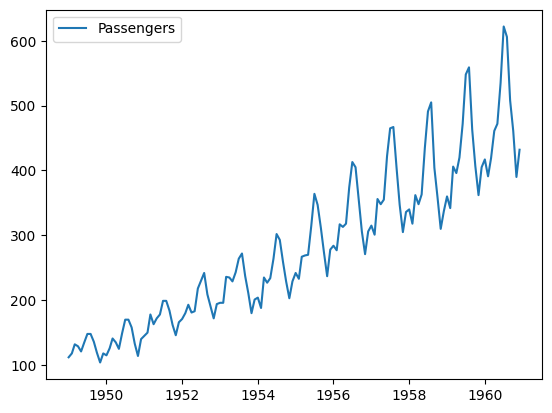

In [10]:
plt.plot(df['Passengers'],  label='Passengers')
plt.legend()
plt.show()

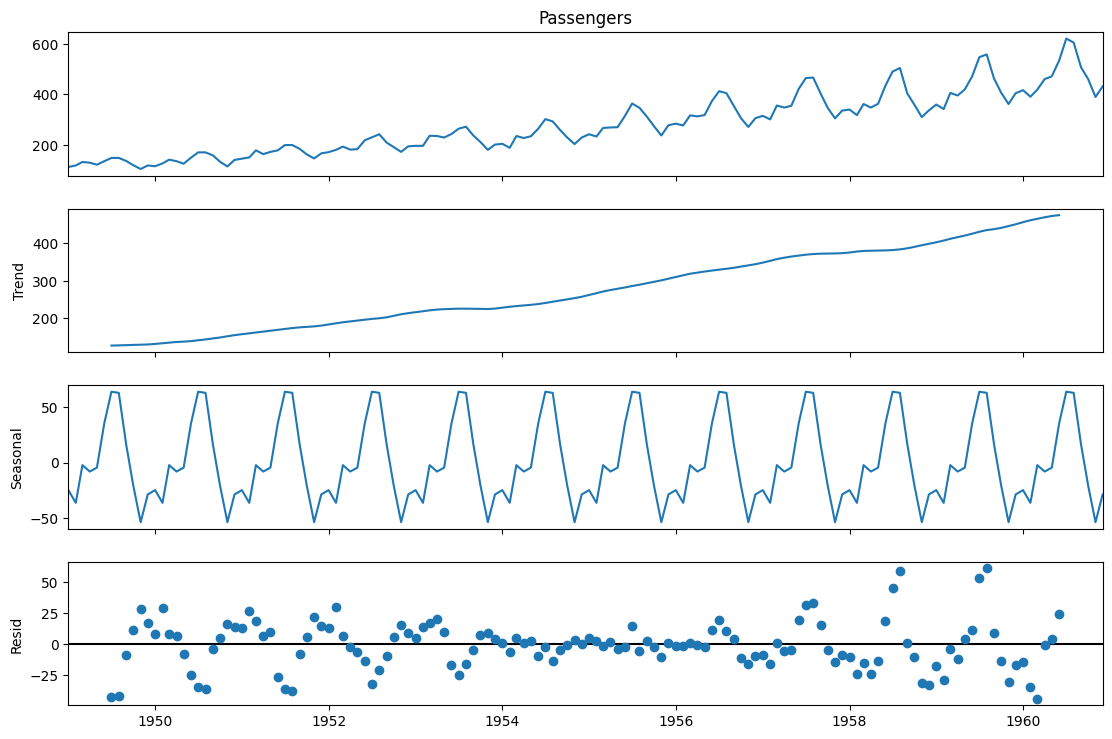

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Passengers'], model='additive', period=12)

fig = decomposition.plot()

fig.set_size_inches(12, 8)

plt.show()

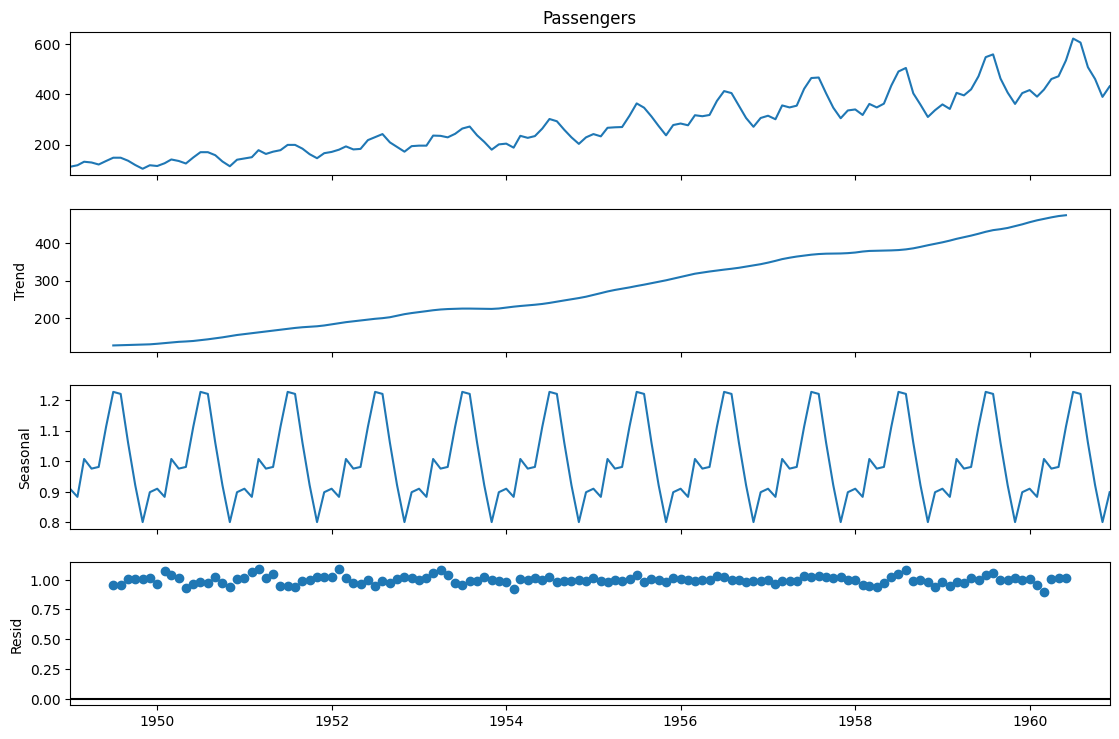

In [12]:
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

fig = decomposition.plot()

fig.set_size_inches(12, 8)

plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller


def fullers_test(time_series):
  result = adfuller(time_series)
  print('ADF Statistic:', result[0])
  print('p-value:', result[1])

  if result[1] <= 0.05:
     print('The time series is stationary.')
  else:
     print('The time series is non-stationary.')

fullers_test(df['Passengers'])

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
The time series is non-stationary.


In [14]:
df['1st_Diff'] = df['Passengers'] - df['Passengers'].shift(1)
df.head()

,Passengers,1st_Diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [15]:
fullers_test(df['1st_Diff'].dropna())

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478
The time series is non-stationary.


In [16]:
df['2nd_Diff'] = df['1st_Diff'] - df['1st_Diff'].shift(1)
df.head()

,Passengers,1st_Diff,2nd_Diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [17]:
fullers_test(df['2nd_Diff'].dropna())

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29
The time series is stationary.


In [18]:
df['seasonal_differencing'] = df['Passengers'] - df['Passengers'].shift(12)
df.head()

,Passengers,1st_Diff,2nd_Diff,seasonal_differencing
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


In [19]:
fullers_test(df['seasonal_differencing'].dropna())

ADF Statistic: -3.383020726492481
p-value: 0.011551493085514952
The time series is stationary.


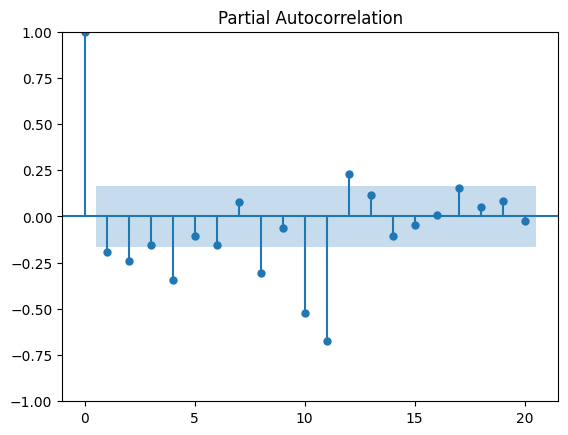

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df['2nd_Diff'].dropna(), lags = 20)
plt.show()

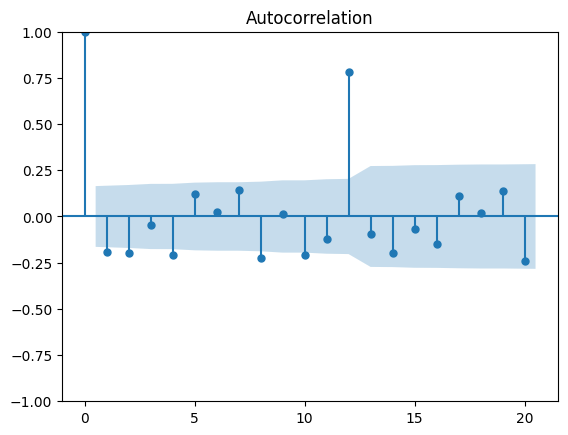

In [21]:
plot_acf(df['2nd_Diff'].dropna(), lags = 20)
plt.show()

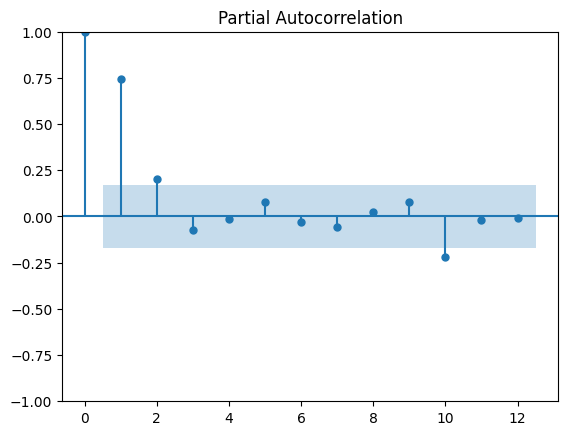

In [22]:
plot_pacf(df['seasonal_differencing'].dropna(), lags = 12)
plt.show()

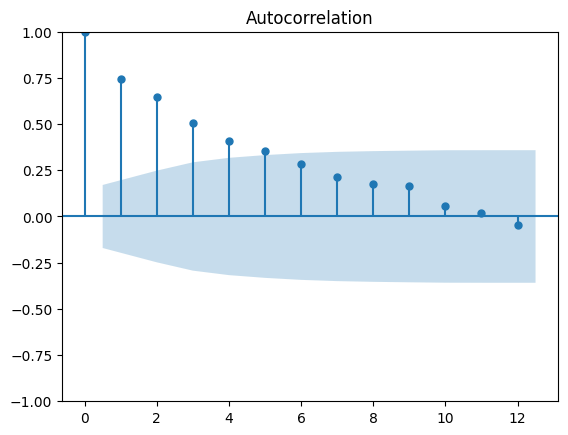

In [23]:
plot_acf(df['seasonal_differencing'].dropna(), lags = 12)
plt.show()

In [26]:
import pmdarima as pm

auto_arima = pm.auto_arima(df['Passengers'], seasonal=True, m=12, trace=True, suppress_warnings=True)
print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=9.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=1.43 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=3.29 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=1.72 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=7.04 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.14 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.29 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.69 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.68 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.38 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(3,1,1)(0,1,0

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Passengers'], order=(2,1,1), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Tue, 07 Jan 2025   AIC                           1017.847
Time:                                     13:59:24   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      

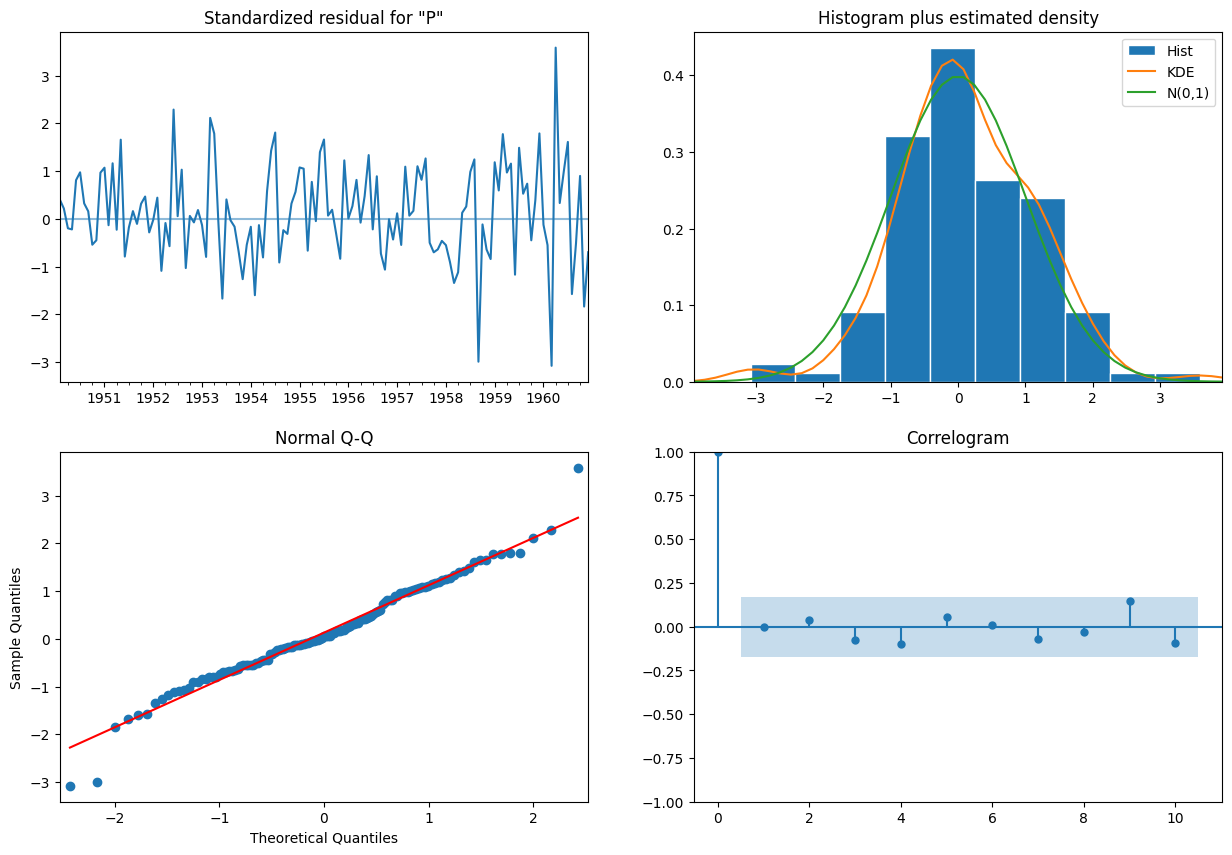

In [28]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid
lb_test = acorr_ljungbox(residuals, lags=20)

print(lb_test)

      lb_stat  lb_pvalue
1    0.000685   0.979116
2    0.809904   0.667009
3    0.923785   0.819684
4    1.360815   0.850976
5    1.907178   0.861834
6    1.961441   0.923210
7    2.709812   0.910488
8    3.211956   0.920360
9    3.325101   0.950001
10   5.583012   0.848996
11   5.628853   0.896946
12  15.892955   0.196188
13  16.279938   0.234343
14  16.322976   0.294051
15  16.324143   0.360842
16  18.514052   0.294666
17  18.696047   0.346255
18  18.874900   0.399565
19  19.934809   0.398511
20  20.712029   0.414253


In [30]:
df.tail()

,Passengers,1st_Diff,2nd_Diff,seasonal_differencing
Month,,,,
1960-08-01,606,-16.0,-103.0,47.0
1960-09-01,508,-98.0,-82.0,45.0
1960-10-01,461,-47.0,51.0,54.0
1960-11-01,390,-71.0,-24.0,28.0
1960-12-01,432,42.0,113.0,27.0


In [31]:
df['Passengers'].isnull().sum()

0

In [32]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)

forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': forecast_conf_int.iloc[:, 0],
    'Upper CI': forecast_conf_int.iloc[:, 1]
}, index=forecast_index)
forecast_df

,Forecast,Lower CI,Upper CI
1961-01-01,445.634934,423.344848,467.925020
1961-02-01,420.395024,394.235397,446.554652
1961-03-01,449.198348,419.831711,478.564985
1961-04-01,491.839976,460.376259,523.303693
1961-05-01,503.394502,470.380453,536.408552
1961-06-01,566.862471,532.699319,601.025622
1961-07-01,654.260189,619.221129,689.299249
1961-08-01,638.597493,602.879832,674.315155
1961-09-01,540.883739,504.631207,577.136271
1961-10-01,494.126610,457.445838,530.807382


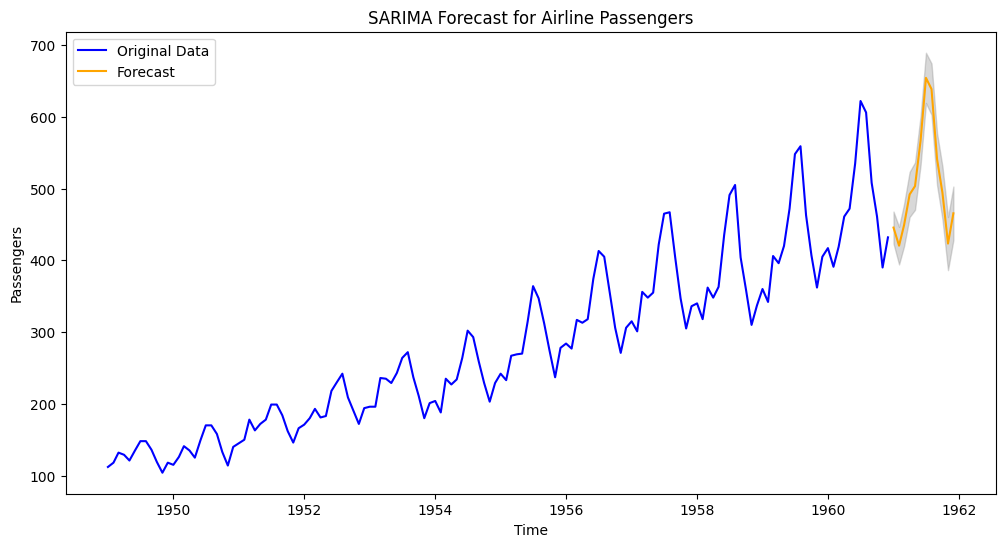

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Original Data', color='blue')
plt.plot(forecast_index, forecast_df['Forecast'], label='Forecast', color='orange')
plt.fill_between(forecast_index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='grey', alpha=0.3)

plt.title('SARIMA Forecast for Airline Passengers')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()


In [49]:
import prophet
from prophet import Prophet

In [50]:
df = pd.read_csv('/content/airline_passengers.csv')
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [51]:
df.tail()

,Month,Thousands of Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [52]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [53]:
prophet_df = df.rename(columns={'Month': 'ds', 'Thousands of Passengers': 'y'})
prophet_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [54]:
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0r31qmci/bpsmt8fs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0r31qmci/tc0vpgyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24756', 'data', 'file=/tmp/tmp0r31qmci/bpsmt8fs.json', 'init=/tmp/tmp0r31qmci/tc0vpgyr.json', 'output', 'file=/tmp/tmp0r31qmci/prophet_modelkf7v0z5u/prophet_model-20250107140920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
prophet_model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None})])

In [56]:
len(prophet_df)

144

In [57]:
future_data = prophet_model.make_future_dataframe(periods=12, freq='MS')
future_data.tail()

,ds
151,1961-08-01
152,1961-09-01
153,1961-10-01
154,1961-11-01
155,1961-12-01


In [58]:
forecast = prophet_model.predict(future_data)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,113.457154,89.240640,116.327185,113.457154,113.457154,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,0.0,0.0,0.0,103.222279
1,1949-02-01,115.212069,86.047471,113.152456,115.212069,115.212069,-0.133979,-0.133979,-0.133979,-0.133979,-0.133979,-0.133979,0.0,0.0,0.0,99.776094
2,1949-03-01,116.797153,100.492173,127.753767,116.797153,116.797153,-0.021072,-0.021072,-0.021072,-0.021072,-0.021072,-0.021072,0.0,0.0,0.0,114.336052
3,1949-04-01,118.552067,103.054952,129.228604,118.552067,118.552067,-0.023166,-0.023166,-0.023166,-0.023166,-0.023166,-0.023166,0.0,0.0,0.0,115.805724
4,1949-05-01,120.250372,106.726125,132.791003,120.250372,120.250372,-0.012221,-0.012221,-0.012221,-0.012221,-0.012221,-0.012221,0.0,0.0,0.0,118.780781


In [59]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
151,1961-08-01,636.618772,663.531188,650.134147
152,1961-09-01,540.173796,567.442038,553.278883
153,1961-10-01,475.736384,502.242069,489.109187
154,1961-11-01,411.096405,438.200319,424.616629
155,1961-12-01,460.397207,486.579664,473.655141


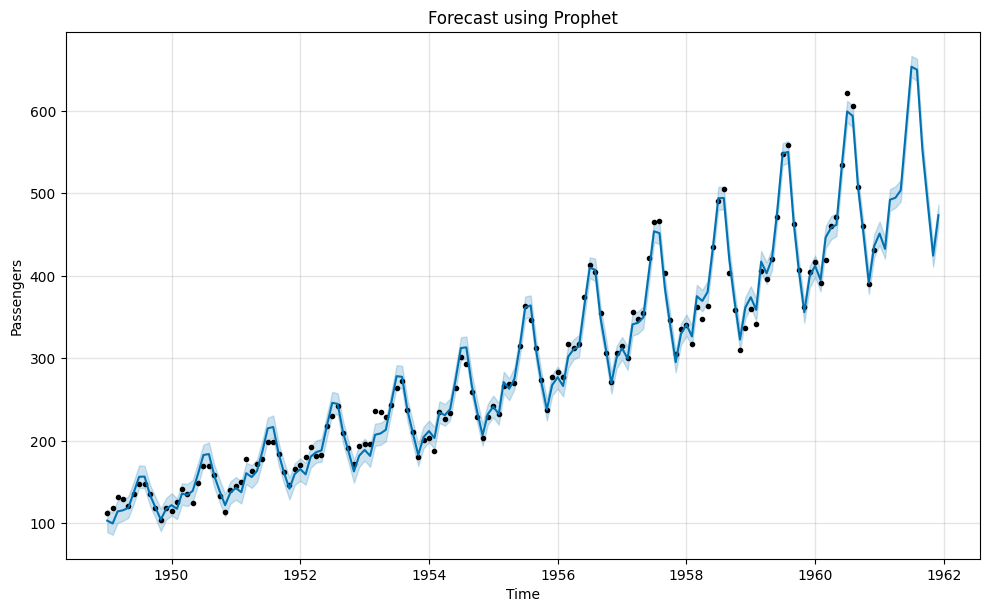

In [60]:
prophet_model.plot(forecast)
plt.title('Forecast using Prophet')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()


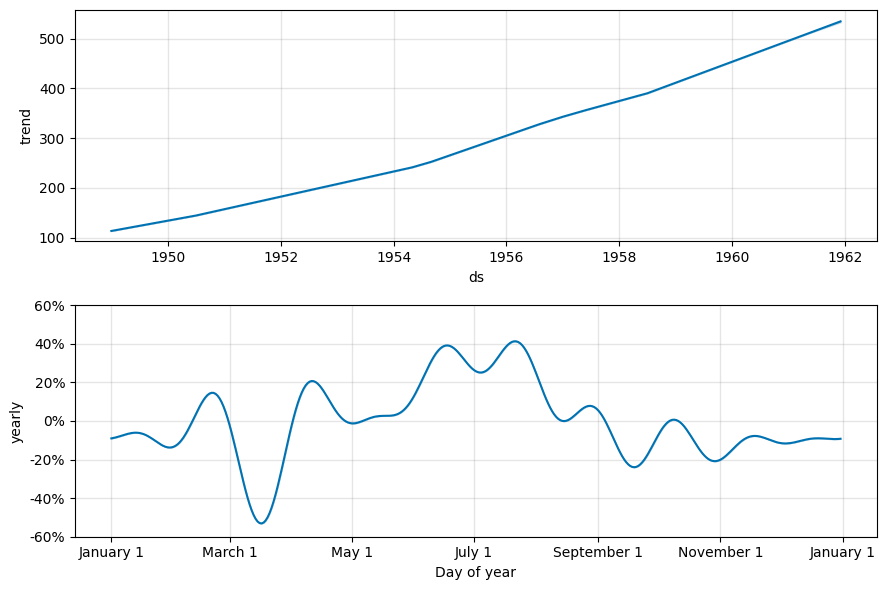

In [61]:
prophet_model.plot_components(forecast)
plt.show()


In [64]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

merged_data = forecast.merge(prophet_df[['ds', 'y']], on='ds', how='left')

merged_data = merged_data.dropna(subset=['y'])

mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])
mape = mean_absolute_percentage_error(merged_data['y'], merged_data['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")



Mean Absolute Error (MAE): 7.995876541948846
Mean Absolute Percentage Error (MAPE): 0.03343850716636969
